# Librerias

**Para replicar los gráficos solo hace falta importar las librerías y bajar hasta el final en donde se encuetra la sección de plots**


In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms

import matplotlib.pyplot as plt
import numpy as np
import os
#
from PIL import Image

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# SAVE_PATH = "" #Local
SAVE_PATH = "/content/gdrive/MyDrive/VGG"

# Modelo

In [4]:
class EncoderVGG16(nn.Module):
    def __init__(self,
                 n_layers = 5,
                 h_dims = [512,256,128,10]):

        super(EncoderVGG16,self).__init__()
        self.n_layers = n_layers
        self.h_dims = h_dims
        self.layers = [5,10,17,24,31]
        self.full_vgg16 = torchvision.models.vgg16()
        self.vgg = self.full_vgg16.features[:self.layers[self.n_layers-1]]

        self.classifier = self.full_vgg16.classifier


        self.classifier[0] = nn.Linear(self.h_dims[0], self.h_dims[1])
        self.classifier[3] = nn.Linear(self.h_dims[1], self.h_dims[2])
        self.classifier[6] = nn.Linear(self.h_dims[2], self.h_dims[3])


    def encode(self,x, layer = 5):
        return self.vgg[:self.layers[layer-1]](x)

    def forward(self,x):
        latent = self.encode(x)
        latent = torch.flatten(latent,start_dim = 1)
        output = self.classifier(latent)

        return output

In [5]:
model = EncoderVGG16()
# model.vgg, model.classifier

In [ ]:
# model.load_state_dict(torch.load("/content/gdrive/MyDrive/VGG/clean_params/bestVGGParamsClean.pt"))

<All keys matched successfully>

# Dataset

In [6]:
if not os.path.exists("data"):
    os.makedirs("data")
    print("Data directory created :D")

if not os.path.exists("data/train"):
    os.makedirs("data/train")
    print("Data train directory created :D")

if not os.path.exists("data/val"):
    os.makedirs("data/val")
    print("Data val directory created :D")


Data directory created :D
Data train directory created :D
Data val directory created :D


In [7]:
train_type = "linear_params"
final_save = os.path.join(SAVE_PATH,train_type)
if not os.path.exists(final_save):
    os.makedirs(final_save)
    print("Data directory created :D")


Data directory created :D


In [11]:
from img_corrupts import *

In [8]:
transform = transforms.Compose([
     transforms.ToTensor(),
    #  transforms.Lambda(pixel_permute),
    #  transforms.Normalize(mean=[0.49139968, 0.48215827 ,0.44653124],std=[0.24703233, 0.24348505, 0.26158768]),
     ])
tensor = transforms.ToTensor()

In [9]:
# train_dataset = torchvision.datasets.CIFAR10(root = "data/train/",train=True, transform= None, download=True)
# val_dataset = torchvision.datasets.CIFAR10(root = "data/val/",train = False, transform= None, download=True)
train_dataset = torchvision.datasets.CIFAR10(root = "data/train/",train=True, transform= transform,download=True)
val_dataset = torchvision.datasets.CIFAR10(root = "data/val/",train = False, transform= tensor, download=True)

100%|██████████| 170498071/170498071 [00:02<00:00, 63993783.65it/s]


Extracting data/train/cifar-10-python.tar.gz to data/train/


100%|██████████| 170498071/170498071 [00:04<00:00, 41194886.73it/s]


Extracting data/val/cifar-10-python.tar.gz to data/val/


In [13]:
# random_labels(train_dataset, 0.4)
torch.manual_seed(0)
lineal_imgs(train_dataset, 0.6)

In [ ]:
train_image_zero, train_target_zero =train_dataset[0]
# transforms.ToPILImage()(train_image_zero)

In [ ]:
train_target_zero

4

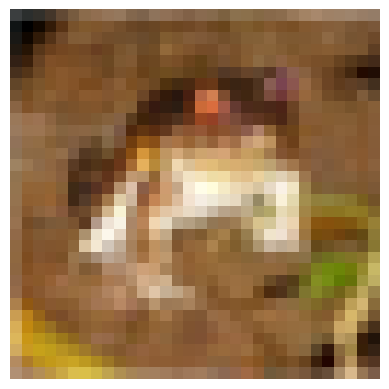

In [ ]:
# plt.imshow(np.transpose(train_image_zero, (0, 1, 2)))
# plt.axis("off")
# plt.show()

In [11]:
train_dataset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: data/train/
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Lambda()
           )

In [12]:
val_dataset

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: data/val/
    Split: Test
    StandardTransform
Transform: ToTensor()

# DataLoaders y criterios de optimización

In [14]:
trainloader = DataLoader(train_dataset, batch_size=1000,shuffle=False,)
valloader = DataLoader(val_dataset,batch_size= 1000,shuffle= False)

In [ ]:
def get_mean_std(trainLoader):
    imgs = None
    for batch in trainLoader:
        image_batch = batch[0]
        if imgs is None:
            imgs = image_batch.cpu()
        else:
            imgs = torch.cat([imgs, image_batch.cpu()], dim=0)
    imgs = imgs.numpy()

    # calculate mean over each channel (r,g,b)
    mean_r = imgs[:,0,:,:].mean()
    mean_g = imgs[:,1,:,:].mean()
    mean_b = imgs[:,2,:,:].mean()
    print(mean_r,mean_g,mean_b)

    # calculate std over each channel (r,g,b)
    std_r = imgs[:,0,:,:].std()
    std_g = imgs[:,1,:,:].std()
    std_b = imgs[:,2,:,:].std()
    print(std_r,std_g,std_b)

In [ ]:
# get_mean_std(trainloader)

0.49139965 0.48215905 0.44653094
0.24703224 0.24348511 0.26158786


In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = 0.0005, weight_decay= 1e-6)

# Entrenamiento

In [16]:
def train_epoch(model, train_loader, criterion, optimizer, cuda):

    total = 0
    correct = 0
    train_loss = 0

    model.train()
    for i, data in enumerate(train_loader):
        if i % 25 == 0:
            print(f"Batch {i}/{len(train_loader)}")

        inputs, labels = data

        if cuda:
            inputs = inputs.cuda()
            labels = labels.cuda()

        optimizer.zero_grad()

        outputs = model(inputs)
        # print(outputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        train_loss += loss.item()

    accuracy = correct/total
    train_loss = train_loss / len(train_loader)
    return train_loss, accuracy

def validate(model, val_loader, criterion, cuda):

    correct = 0
    val_loss = 0
    total = 0

    model.eval()
    with torch.no_grad():
        for data in val_loader:

            inputs, labels = data

            if cuda:
                inputs = inputs.cuda()
                labels = labels.cuda()

            outputs = model(inputs)

            loss = criterion(outputs,labels)

            total += labels.size(0)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            val_loss += loss.item()

    val_loss = val_loss / len(val_loader)
    accuracy = correct/total
    return val_loss, accuracy

In [17]:
def training(model,
             epochs,
             train_loader,
             val_loader,
             criterion,
             optimizer,
             each = 50,
             state = None,
             name = "",
             cuda = True):

    # If trained before
    if state == None:
        state = {
            "epoch" : 0,
            "loss" : [[], []], # [train, val]
            "acc" : [[], []], # [train, val]
            "params" : None,
            "bestloss" : np.inf
        }

    # If previously trained
    else:
        state = torch.load(state)
        model.load_state_dict(state["params"])

    best_loss = state["bestloss"]
    state_epochs = state["epoch"]

    if cuda:
        model = model.cuda()

    for epoch in range(state_epochs, state_epochs + epochs):
        print(f"Epoch nro {epoch + 1}/{epochs}")

        # Train
        # torch.manual_seed(0)
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, cuda)
        # Val
        val_loss, val_acc = validate(model, val_loader,criterion, cuda)

        print(f"Train loss = {train_loss}, Val loss = {val_loss}")
        print(f"Train acc = {train_acc}, Val acc = {val_acc}")
        # print(f"Val acc = {val_acc}")

        if (best_loss > val_loss):
            best_loss = val_loss
            print(f"Better params found in epoch = {epoch + 1}, saved params")
            torch.save(model.state_dict(), os.path.join(final_save,f'bestVGGParams{name}.pt'))


        # Save periodically for each
        if ((epoch + 1)%each == 0):
            print(f"Se ha guardado la época múltiplo de {each}")
            torch.save(model.state_dict(), os.path.join(final_save,f'eachVGGParams_{name}_{epoch + 1}.pt'))

        # Update state
        state["loss"][0].append(train_loss)
        state["loss"][1].append(val_loss)
        state["acc"][0].append(train_acc)
        state["acc"][1].append(val_acc)
        state["epoch"] = epoch + 1
        state["params"] = model.state_dict()
        state["bestloss"] = best_loss

        # Save per epoch just in case
        torch.save(state, os.path.join(final_save,f"VGG{name}_state.pt"))
    return state["loss"]

In [18]:
# state_dir = "/content/gdrive/MyDrive/VGG/gauss04_params/VGGGauss04_state.pt"
# state_dir = "/content/gdrive/MyDrive/VGG/SEEDgauss04_params/VGGsGauss04_state.pt"
# state_dir = "/content/gdrive/MyDrive/VGG/rand04_params/VGGRand04_state.pt"
# state_dir = "/content/gdrive/MyDrive/VGG/fixedperm_params/VGGFPixelPerm_state.pt"
# state_dir = "/content/gdrive/MyDrive/VGG/linear_params/VGGLinear_state.pt"

In [18]:
train_state = training(model = model,
                     epochs = 100,
                     train_loader = trainloader,
                     val_loader = valloader,
                     criterion = criterion,
                     optimizer = optimizer,
                     each = 10,
                     state = None,#None, #If trained state_dir
                     name = "Linear",
                     cuda = True,)

Epoch nro 1/100
Batch 0/50
Batch 25/50
Train loss = 2.3074776887893678, Val loss = 2.302678632736206
Train acc = 0.10682, Val acc = 0.1004
Better params found in epoch = 1, saved params
Epoch nro 2/100
Batch 0/50
Batch 25/50
Train loss = 2.236557273864746, Val loss = 2.077780079841614
Train acc = 0.13748, Val acc = 0.1842
Better params found in epoch = 2, saved params
Epoch nro 3/100
Batch 0/50
Batch 25/50
Train loss = 2.0574984169006347, Val loss = 1.9210899949073792
Train acc = 0.16912, Val acc = 0.1943
Better params found in epoch = 3, saved params
Epoch nro 4/100
Batch 0/50
Batch 25/50
Train loss = 1.9909296536445618, Val loss = 1.8631421208381653
Train acc = 0.17662, Val acc = 0.1985
Better params found in epoch = 4, saved params
Epoch nro 5/100
Batch 0/50
Batch 25/50
Train loss = 1.9177993154525756, Val loss = 1.7780025959014893
Train acc = 0.22004, Val acc = 0.287
Better params found in epoch = 5, saved params
Epoch nro 6/100
Batch 0/50
Batch 25/50
Train loss = 1.837946617603302

# Plots

**Para replicar comentar la lista de direcciones a drive y descomentar la de abajo añadiendo la dirección de los parámetros del drive**

[]

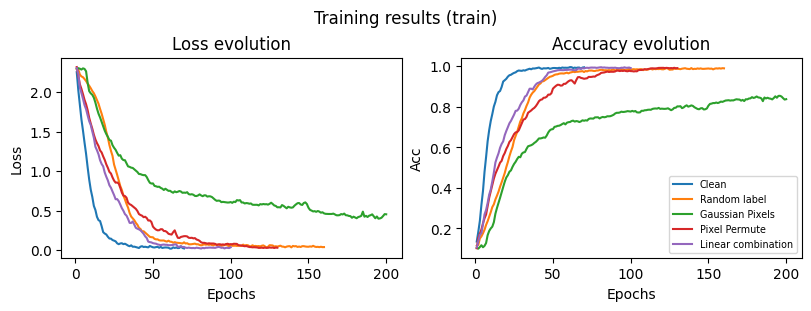

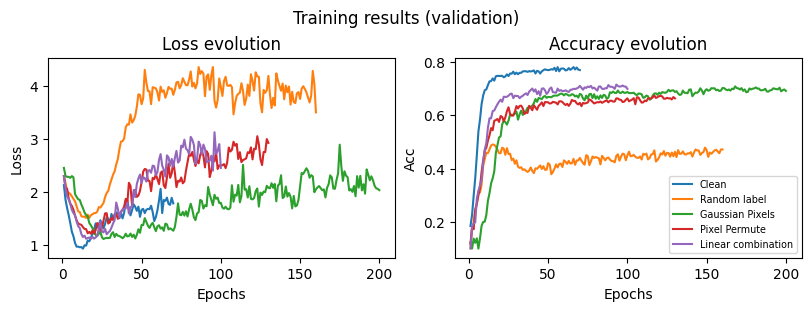

In [3]:
state_dirs = ["/content/gdrive/MyDrive/VGG/clean_params/VGGClean_state.pt",
              "/content/gdrive/MyDrive/VGG/rand04_params/VGGRand04_state.pt",
              # "/content/gdrive/MyDrive/VGG/gauss04_params/VGGGauss04_state.pt",
              "/content/gdrive/MyDrive/VGG/SEEDgauss04_params/VGGsGauss04_state.pt",
              "/content/gdrive/MyDrive/VGG/fixedperm_params/VGGFPixelPerm_state.pt",
              "/content/gdrive/MyDrive/VGG/linear_params/VGGLinear_state.pt",
              ]

# state_dirs = [".\\VGGClean_state.pt",
#               ".\\VGGRand04_state.pt",
#               # ".\\VGGGauss04_state.pt",
#               ".\\VGGsGauss04_state.pt",
#               ".\\VGGFPixelPerm_state.pt",
#               ".\\VGGLinear_state.pt",
#               ]

n_curves = len(state_dirs)

states = []
for i in range(n_curves):
    states.append(torch.load(state_dirs[i]))

labels =["Clean",
         "Random label",
         "Gaussian Pixels",
        #  "Fixed Gaussian Pixels",
         "Pixel Permute",
         "Linear combination"]

fig, (train_loss,train_acc) = plt.subplots(ncols = 2, figsize = (8,3), layout = "constrained")
fig.suptitle("Training results (train)")

for i, state in enumerate(states):
    n_epochs = np.arange(1,len(state["loss"][0]) + 1,1)
    train_loss.plot(n_epochs , state["loss"][0], label = labels[i])
    train_acc.plot(n_epochs , state["acc"][0], label = labels[i])

train_loss.set_xlabel("Epochs")
train_loss.set_ylabel("Loss")
train_loss.set_title("Loss evolution")

train_acc.set_xlabel("Epochs")
train_acc.set_ylabel("Acc")
train_acc.set_title("Accuracy evolution")

plt.legend(fontsize = "x-small")
plt.savefig("img_train.pdf")
plt.plot()

fig, (val_loss,val_acc) = plt.subplots(ncols = 2, figsize = (8,3), layout = "constrained")
fig.suptitle("Training results (validation)")

for i, state in enumerate(states):
    n_epochs = np.arange(1,len(state["loss"][0]) + 1 ,1)
    val_loss.plot(n_epochs , state["loss"][1], label = labels[i])
    val_acc.plot(n_epochs , state["acc"][1], label = labels[i])

val_loss.set_xlabel("Epochs")
val_loss.set_ylabel("Loss")
val_loss.set_title("Loss evolution")

val_acc.set_xlabel("Epochs")
val_acc.set_ylabel("Acc")
val_acc.set_title("Accuracy evolution")

plt.legend(fontsize = "x-small")
plt.savefig("img_val.pdf")
plt.plot()



In [7]:
for i, state in enumerate(states):
    print(labels[i])
    # pos = np.argmin(state["loss"][1])
    t = state["acc"][0][-1] * 100
    v = state["acc"][1][-1]* 100
    print(f"Train acc {t}")
    print(f"Val acc {v}")



Clean
Train acc 99.446
Val acc 76.94
Random label
Train acc 98.942
Val acc 47.19
Gaussian Pixels
Train acc 83.738
Val acc 69.11
Pixel Permute
Train acc 99.048
Val acc 66.34
Linear combination
Train acc 99.072
Val acc 69.89999999999999
